In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv('D:/Proyectos personales/fraud-detection/data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- The database was transformed using PCA, which is why its components look like this. Additionally, for confidentiality reasons, the features were hidden; only the transaction amount and its status as fraudulent or not are maintained in a human-readable and understandable way.

*Note: feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.*

In [4]:
df.shape

(284807, 31)

# Data Cleaning

In [5]:
have_nan = df.isnull().any().any() 
have_nan

np.False_

The data integrity check confirms the database is free of NaN representations.

In [6]:
have_duplicates = df.duplicated().sum()
have_duplicates #

np.int64(1081)

There are some duplicates, however they will not be removed due to the possibility that they are an effect of the PCA process

The database is already clean

# Descriptive analysis

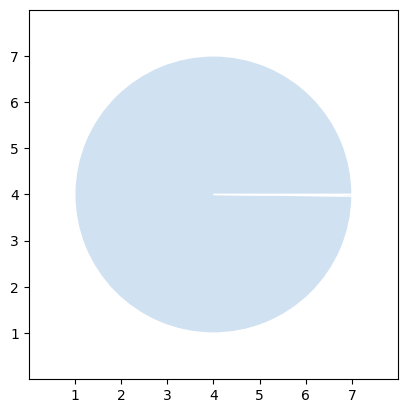

In [7]:
count = df['Class'].value_counts()

colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(count)))

# plot
fig, ax = plt.subplots()
ax.pie(count, colors=colors, radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()
plt.show()

In [8]:
prop = pd.DataFrame(count)  
prop['proportion'] = (prop['count']/prop['count'].sum())*100
prop

,count,proportion
Class,,
0,284315,99.827251
1,492,0.172749


The class imbalance ratio is really high, so it's logic use models for manage this issue, like XGBoost

# Modeling

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Split Data

In [10]:
X = df.drop(columns='Class')
y = df['Class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## First Training of Model

In [13]:
scale_pos_weight = prop['count'][0]/prop['count'][1]
scale_pos_weight =float(scale_pos_weight)
scale_pos_weight

577.8760162601626

In [14]:
# Def Para
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'eta': 0.1,  # Tasa de aprendizaje
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': ['logloss', 'error']
}
num_round = 100 # Tree number

# Train
bst = xgb.train(params, dtrain, num_round)

# Pred
preds = bst.predict(dtest)

In [15]:
preds #prob of Fraud 

array([0.99927443, 0.00415936, 0.03706714, ..., 0.0098279 , 0.02754576,
       0.03125114], shape=(85443,), dtype=float32)

### First metrics

In [16]:
threshold = 0.5
y_pred_clase = np.where(preds > threshold, 1, 0) #hard pred
y_pred_clase

array([1, 0, 0, ..., 0, 0, 0], shape=(85443,))

In [17]:
y_true = dtest.get_label()
y_true

array([1., 0., 0., ..., 0., 0., 0.], shape=(85443,), dtype=float32)

In [18]:
# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred_clase)
print(f"Accuracy: {accuracy:.4f}")


conf_matrix = confusion_matrix(y_true, y_pred_clase)
print("\nMatrix")
print(conf_matrix)
# 

# 3. Precision, Recall, F1-Score
report = classification_report(y_true, y_pred_clase)
print("\nReport")
print(report)

Accuracy: 0.9933

Matrix
[[84744   563]
 [   11   125]]

Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     85307
         1.0       0.18      0.92      0.30       136

    accuracy                           0.99     85443
   macro avg       0.59      0.96      0.65     85443
weighted avg       1.00      0.99      1.00     85443



Note that the f1-score indicates that the model has trouble identifying the minority class (fraud).

## Cross Validation

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [20]:
f1_scorer = make_scorer(f1_score)

In [21]:
param_grid = params = {
    'max_depth': [3,6, 8],
    'learning_rate': [0.1, 0.2, 0.06],  # Tasa de aprendizaje
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight+2, scale_pos_weight-3],
    'n_estimators': [100, 250, 300] 
}


In [22]:
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='logloss', objective='binary:logistic'),
    param_grid=param_grid,
    scoring=f1_scorer, 
    cv=5,
    verbose=1
)

In [23]:
grid_search.fit(X_train, y_train)

# best_estimator
print(f"Mejor F1-Score: {grid_search.best_score_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejor F1-Score: 0.8580240966586572


In [26]:
best_model = grid_search.best_estimator_

y_pred_class = best_model.predict(X_test)

In [27]:
y_true = dtest.get_label()
y_true

array([1., 0., 0., ..., 0., 0., 0.], shape=(85443,), dtype=float32)

In [29]:
report = classification_report(y_true, y_pred_class)
print("\nReport")
print(report)


Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85307
         1.0       0.93      0.85      0.88       136

    accuracy                           1.00     85443
   macro avg       0.96      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



- Note how the F1 metric was high for the minority class.
- The recall indicates that 85% of fraudulent transactions were found in the database.
- The high precision indicates that the model only gave false positives 7% of the time.